In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data_url = "./data/coffee_shop_export.csv"

df = pd.read_csv(data_url)
df.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,1/1/2023,2025-06-15 07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,1/1/2023,2025-06-15 07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,1/1/2023,2025-06-15 07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,1/1/2023,2025-06-15 07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,1/1/2023,2025-06-15 07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


In [5]:
# Convert to datetime if it's not already
df['transaction_time'] = pd.to_datetime(df['transaction_time'])
df['transaction_time'] = df['transaction_time'].dt.time

# First, ensure both are strings
df['transaction_date'] = df['transaction_date'].astype(str)
df['transaction_time'] = df['transaction_time'].astype(str)

# Combine the two into a single datetime column
df['timestamp'] = pd.to_datetime(df['transaction_date'] + ' ' + df['transaction_time'], format="%m/%d/%Y %H:%M:%S")
print(df['timestamp'].head(2))

0   2023-01-01 07:06:11
1   2023-01-01 07:08:56
Name: timestamp, dtype: datetime64[ns]


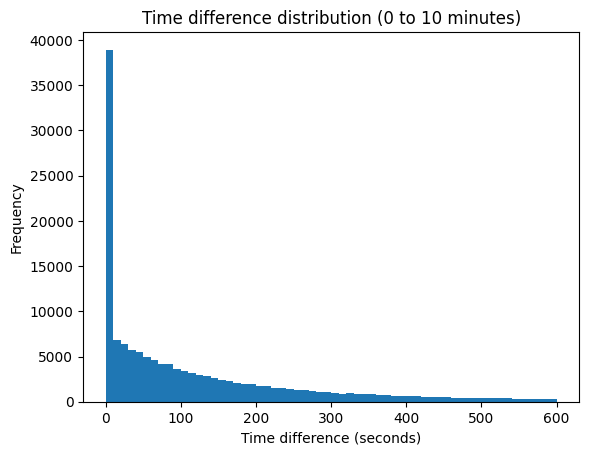

In [6]:
# Assuming df is sorted and has 'time_diff' column calculated as before
df = df.sort_values(['store_location', 'timestamp']).reset_index(drop=True)
df['prev_timestamp'] = df.groupby('store_location')['timestamp'].shift(1)
df['time_diff'] = (df['timestamp'] - df['prev_timestamp']).dt.total_seconds()

# Filter time differences between 0 and 600 seconds (10 minutes)
filtered_time_diff = df['time_diff'][(df['time_diff'] >= 0) & (df['time_diff'] <= 600)]

# Plot histogram
plt.hist(filtered_time_diff.dropna(), bins=60)
plt.xlabel('Time difference (seconds)')
plt.ylabel('Frequency')
plt.title('Time difference distribution (0 to 10 minutes)')
plt.show()

In [7]:
# Sort by store and timestamp
df = df.sort_values(['store_location', 'timestamp']).reset_index(drop=True)

basket_id = 0
basket_ids = []

# Keep track of last timestamp per store
last_timestamp_per_store = {}

time_window_seconds = 300  # 5 minutes, adjust as needed

for idx, row in df.iterrows():
    store = row['store_location']
    timestamp = row['timestamp']
    
    if store not in last_timestamp_per_store:
        # First entry for this store
        basket_id += 1
    else:
        # Calculate time difference in seconds from last timestamp
        diff = (timestamp - last_timestamp_per_store[store]).total_seconds()
        if diff > time_window_seconds:
            basket_id += 1  # New basket after time gap
    
    basket_ids.append(basket_id)
    last_timestamp_per_store[store] = timestamp

df['basket_id'] = basket_ids
df.head(2)

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,timestamp,prev_timestamp,time_diff,basket_id
0,106,1/1/2023,11:01:48,1,3,Astoria,22,2.00,Coffee,Drip coffee,Our Old Time Diner Blend Sm,2023-01-01 11:01:48,NaT,NaN,1
1,107,1/1/2023,11:01:58,1,3,Astoria,38,3.75,Coffee,Barista Espresso,Latte,2023-01-01 11:01:58,2023-01-01 11:01:48,10.0,1


In [8]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

location_df = df[df['store_location'] == 'Lower Manhattan']

# Group by basket_id and get product_detail list per transaction
basket = location_df.groupby('basket_id')['product_detail'].apply(list).tolist()

# Encode transactions
te = TransactionEncoder()
te_ary = te.fit_transform(basket)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Apply Apriori to find frequent itemsets
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)

# Get association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Sort by highest lift to find best bundles
rules = rules.sort_values(by='lift', ascending=False)

# Filtering rules by support, confidence, and lift thresholds
filtered_rules = rules[
    (rules['support'] > 0.01) &       # Support > 1%
    (rules['confidence'] > 0.5) &     # Confidence > 50%
    (rules['lift'] > 3)                # Lift > 3 (strong association)
]

def format_rule(row):
    antecedents = ', '.join(list(row['antecedents']))
    consequents = ', '.join(list(row['consequents']))
    support = row['support']
    confidence = row['confidence']
    lift = row['lift']
    
    return (f"At location 'Lower Manhattan', customers who buy [{antecedents}] "
            f"also tend to buy [{consequents}].\n"
            f"  - Support: {support:.2%}, Confidence: {confidence:.2%}, Lift: {lift:.2f}\n"
            f"  => This bundle is strongly recommended.\n")

# Print only top 10 filtered rules
for _, row in filtered_rules.head(10).iterrows():
    print(format_rule(row))

At location 'Lower Manhattan', customers who buy [Hazelnut syrup, Sugar Free Vanilla syrup] also tend to buy [Cappuccino].
  - Support: 1.04%, Confidence: 58.62%, Lift: 6.47
  => This bundle is strongly recommended.

At location 'Lower Manhattan', customers who buy [Chocolate syrup, Carmel syrup] also tend to buy [Latte Rg].
  - Support: 1.02%, Confidence: 62.69%, Lift: 6.40
  => This bundle is strongly recommended.

At location 'Lower Manhattan', customers who buy [Cappuccino, Peppermint Lg] also tend to buy [Sugar Free Vanilla syrup].
  - Support: 1.01%, Confidence: 53.90%, Lift: 6.33
  => This bundle is strongly recommended.

At location 'Lower Manhattan', customers who buy [Sugar Free Vanilla syrup, Chocolate syrup] also tend to buy [Cappuccino].
  - Support: 1.07%, Confidence: 56.77%, Lift: 6.27
  => This bundle is strongly recommended.

At location 'Lower Manhattan', customers who buy [Sugar Free Vanilla syrup, Hazelnut syrup] also tend to buy [Latte].
  - Support: 1.07%, Confide